# Digital Linear Filters

**Graphical explanation of the differences between standard DLF, lagged convolution DLF, and splined DLF.**

The comments here apply generally to the digital linear filter method. Having `empymod` in mind, they are particularly meant for the Hankel (Bessel-Fourier) transform from the wavenumber-frequency domain ($k-f$) to the space-frequency domain ($x-f$), and for the Fourier transform from the space-frequency domain ($x-f$) to the space-time domain ($x-t$).

### Table of contents
1. [Introduction](#1.-Introduction): Theory
2. [How the DLF works](#2.-How-the-DLF-works): Simple calculation example using a 5 pt filter
3. [Difference between standard, lagged convolution, and splined DLF](#3.-Difference-between-standard,-lagged-convolution,-and-splined-DLF)  
    3.1 [Standard DLF](#3.1-Standard-DLF)  
    3.2 [Lagged Convolution DLF](#3.2-Lagged-Convolution-DLF)  
    3.3 [Splined DLF](#3.3-Splined-DLF)
4. [Example for the Hankel transform](#4.-Example-for-the-Hankel-transform) using `empymod`
5. [Example for the Fourier transform](#5.-Example-for-the-Fourier-transform) using `empymod`

## 1. Introduction

*This introduction is taken from Werthmüller et al. (2018), which can be found in the repo [article-fdesign](https://github.com/empymod/article-fdesign).*

In electromagnetics we often have to evaluate integrals of the form

$$ F(r) = \int^\infty_0 f(l)K(l r)\,dl \ ,$$

where $l$ and $r$ denote input and output evaluation values, respectively, and
$K$ is the kernel function. In the specific case of the Hankel transform $l$
corresponds to wavenumber, $r$ to offset, and $K$ to Bessel functions; in the
case of the Fourier transform $l$ corresponds to frequency, $r$ to time, and
$K$ to sine or cosine functions. In both cases it is an infinite integral which
numerical integration is very time-consuming because of the slow decay of the
kernel function and its oscillatory behaviour.

By substituting $r = e^x$ and $l = e^{-y}$ we get

$$e^x F(e^x) = \int^\infty_{-\infty} f(e^{-y})K(e^{x-y})e^{x-y}\,dy\ .$$

This can be re-written as a convolution integral and be approximated for an
$N$-point filter by

$$ F(r) \approx \sum^N_{n=1} \frac{f(b_n/r) h_n}{r}\ ,$$

where $h$ is the digital linear filter, and the logarithmically spaced filter
abscissae is a function of the spacing $\Delta$ and the shift $\delta$,

$$ b_n = \exp\left\{\Delta(-N/2+n) + \delta\right\} \ . $$

From the penultimate equation it can be seen that the filter method
requires $N$ evaluations at each $r$. For example, to calculate the frequency
domain result for 100 offsets with a 201$\,$pt filter requires 20,100 evaluations
in the wavenumber domain. This is why the DLF often uses interpolation to
minimize the required evaluations, either for $F(r)$ in what is referred to as
*lagged convolution DLF*, or for $f(l)$, which we here call *splined DLF*.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as dc

# Load dipole- and analytical routines; filters
from empymod import dipole, analytical
from empyscripts import fdesign
from empymod import filters

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 100

## 2. How the DLF works

### Design a very short, digital linear filter

For this we use `empyscripts.fdesign`. This is outside the scope of this notebook. If you are interested have a look at the [article-fdesign](https://github.com/empymod/article-fdesign)-repo for more information regarding the design of digital linear filters.

We design a 5pt filter using the theoretical transform pair

$$\int^\infty_0 l \exp\left(-l^2\right) J_0(lr) dl = \exp\left(\frac{-r^2}{4}\right)/2 \ .$$

A 5 pt filter is very short for this problem, so we expect a considerable error level. In designing the filter we force
the filter to be better than a relative error of 5 %.

If you want to play around with this example I recommend to set `verb=2` and `plot=2` to get some feedback from the minimization procedure.

In [3]:
filt = fdesign.design(
        n=5,                        # 5 point filter
        spacing=(0.55, 0.65, 101),
        shift=(0.6, 0.7, 101),
        fI=fdesign.j0_1(),
        r=np.logspace(0, 1, 100),
        r_def=(1, 1, 10),
        error=0.05,                 # 5 % error level. If you set this too low you will
        verb=1,                     #                  not find a filter with only 5 points.
        plot=0,
)

print('Filter base    ::', filt.base)
print('Filter weights ::', filt.j0)

Filter base    :: [ 0.59929579  1.07250818  1.91937574  3.43494186  6.14722033]
Filter weights :: [ 0.84042401 -0.00226984  0.57950981 -0.82310148  0.22837621]


Now we carry out the DLF and check how good it is.

A DLF for this problem with only a 5 pt filter is difficult. We used an error-limit of 0.05
in the filter design, so we expect the result to have a relative error of less than 5 %.

Theoretical value   :: 0.183939720586
DLF value           :: 0.188374812856
Rel. error 5 pt DLF :: 2.4 %.


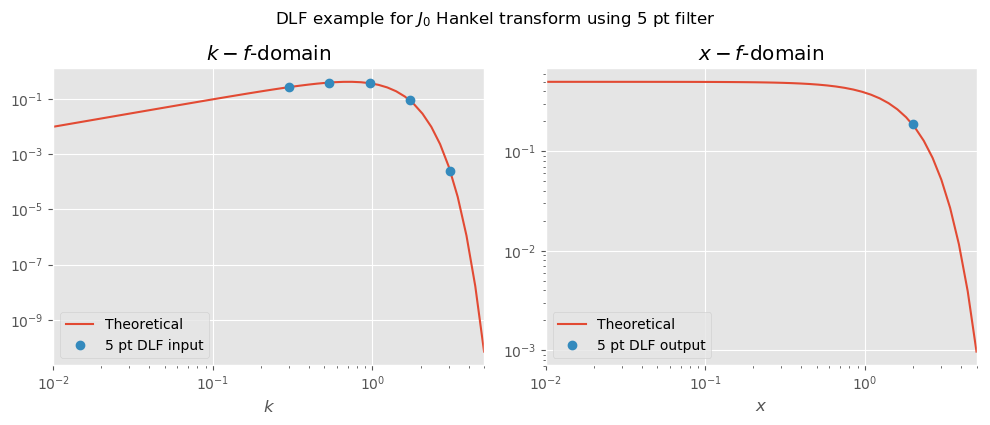

In [4]:
# Desired x-f-domain point (output domain)
x = 2

# Required k-f-domain points (input domain)
k = filt.base/x

# Get the theoretical transform pair
tp = fdesign.j0_1()

# Calculate the value at the five required wavenumbers
k_val = tp.lhs(k)

# Weight the values and sum them up
x_val_filt = np.sum(k_val*filt.j0)/x

# Calculate the theoretical value for comparison
x_val_theo = tp.rhs(x)

# Calculate relative error
print('A DLF for this problem with only a 5 pt filter is difficult. We used an error-limit of 0.05')
print('in the filter design, so we expect the result to have a relative error of less than 5 %.\n')
print('Theoretical value   ::', x_val_theo)
print('DLF value           ::', x_val_filt)
relerror = np.abs((x_val_theo-x_val_filt)/x_val_theo)
print('Rel. error 5 pt DLF ::', np.round(relerror*100, 1), '%.')

# Figure
plt.figure(figsize=(10, 4))
plt.suptitle(r'DLF example for $J_0$ Hankel transform using 5 pt filter', y=1.05)

# x-axis values for the theoretical plots
xk = np.logspace(-2, np.log10(5))

# k-f-domain
plt.subplot(121)
plt.title(r'$k-f$-domain')
plt.loglog(xk, tp.lhs(xk), label='Theoretical')
plt.loglog(k, k_val, 'o', label='5 pt DLF input')
plt.legend()
plt.xlabel(r'$k$')
plt.xlim([xk.min(), xk.max()])

# x-f-domain
plt.subplot(122)
plt.title(r'$x-f$-domain')
plt.loglog(xk, tp.rhs(xk), label='Theoretical')
plt.loglog(x, x_val_filt, 'o', label='5 pt DLF output')
plt.legend()
plt.xlabel(r'$x$')
plt.xlim([xk.min(), xk.max()])

plt.tight_layout()
plt.show()

## 3. Difference between standard, lagged convolution, and splined DLF

Filter weights and the actual DLF are ignored in the explanation, we only look at the required data points in the input domain given our desired points in the output domain.

### General parameters

In [5]:
# Wanted points in the output domain (x-f or x-t domain)
d_out = np.array([0.2, 0.7, 5, 25, 100])

# Made-up filter base for explanatory purpose
base = np.array([1e-2, 1e-1, 1e0, 1e1, 1e2])

## 3.1 Standard DLF

For each point in the output domain you have to calculate $n$ points in the input domain, where $n$ is the filter length.

### Implementation in `empymod`

This is the most precise one, as no interpolation is used, but generally the slowest one. It is the default method for the Hankel transform.

For the **Hankel transform**, use these parameters in `empymod.dipole` or `empymod.bipole`:

    ht = 'fht'                     # Default
    opt = None                     # Default
    htarg = {'pts_per_dec': None}  # Default
    
The standard DLF works also with the parallel option, `opt = 'parallel'`.

For the **Fourier transform**, use these parameters in `empymod.dipole` or `empymod.bipole`:

    ft = 'sin' or 'cos'            # Default is 'sin'
    ftarg = {'pts_per_dec': 0}     # Only implemented from empymod v1.5.2 onwards


Points in output domain  :: 5
Filter length            :: 5
Req. pts in input domain :: 25


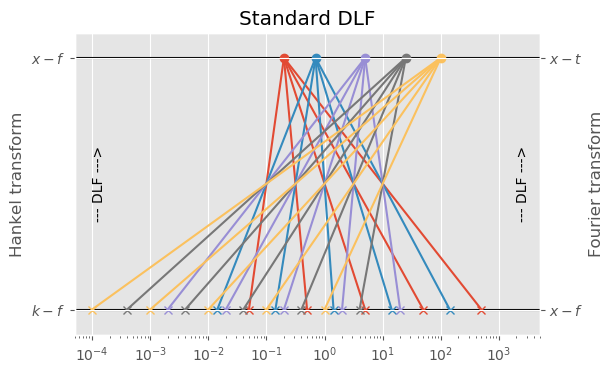

In [6]:
# Required points in the input domain (k-f or x-f domain)
d_in = base/d_out[:,None]

# Print information
print('Points in output domain  ::', d_out.size)
print('Filter length            ::', base.size)
print('Req. pts in input domain ::', d_in.size)

# Figure
plt.figure()
plt.title('Standard DLF')
plt.hlines(1, 1e-5, 1e5)
plt.hlines(0, 1e-5, 1e5)

# Print scheme
for i, val in enumerate(d_out):
    for ii, ival in enumerate(d_in[i, :]):
        plt.plot(ival, 0, 'C'+str(i)+'x')
        plt.plot([ival, val], [0, 1], 'C'+str(i))
    plt.plot(val, 1, 'C'+str(i)+'o')
    
plt.xscale('log')
plt.xlim([5e-5, 5e3])

# Annotations
plt.text(2e3, 0.5, '--- DLF --->', rotation=90, va='center')
plt.text(1e-4, 0.5, '--- DLF --->', rotation=90, va='center')

plt.yticks([0, 1], (r'$k-f$', r'$x-f$'))
plt.ylabel('Hankel transform')
plt.ylim([-0.1, 1.1])

plt.gca().twinx()
plt.yticks([0, 1], (r'$x-f$', r'$x-t$'))
plt.ylabel('Fourier transform')
plt.ylim([-0.1, 1.1])

plt.show()

## 3.2 Lagged Convolution DLF

The spacing of the filter base is used to get from minimum to maximum required input-domain point ($k$ in the case of the Hankel transform, $f$ in the case of the Fourier transform); for each complete set the DLF is executed to calculate the output-domain response ($f$ in the case of the Hankel transform, $t$ in the case of the Fourier transform), and interpolation is carried out in the output-domain.
  
### Implementation in `empymod`

This is usually the fastest option, and generally still more than sufficiently precise. It is the default method for the Fourier transform.

For the **Hankel transform**, use these parameters in `empymod.dipole` or `empymod.bipole`:

    ht = 'fht'                     # Default
    opt = 'spline'
    htarg = {'pts_per_dec': None}  # Default

For the **Fourier transform**, use these parameters in `empymod.dipole` or `empymod.bipole`:

    ft = 'sin' or 'cos'            # Default is 'sin'
    ftarg = {'pts_per_dec': None}  # Default


Points in output-domain  :: 5
Filter length            :: 5
Req. pts in input-domain :: 8


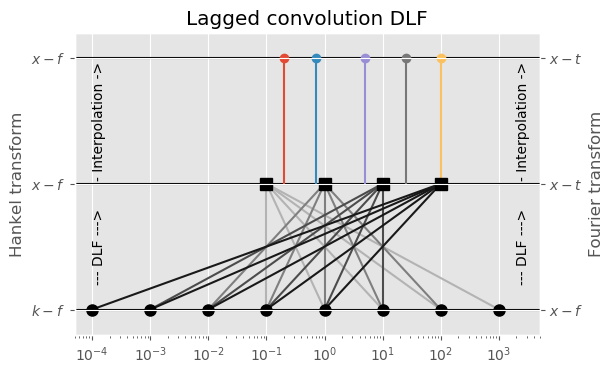

In [7]:
# Required points in the k-domain
d_in2 = np.array([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3])

# Intermediat values in the f-domain
d_out2 = np.array([1e-1, 1e0, 1e1, 1e2])

# Print information
print('Points in output-domain  ::', d_out.size)
print('Filter length            ::', base.size)
print('Req. pts in input-domain ::', d_in2.size)

# Figure
plt.figure()
plt.title('Lagged convolution DLF')
plt.hlines(1, 1e-5, 1e5)
plt.hlines(0, 1e-5, 1e5)
plt.hlines(0.5, 1e-5, 1e5)

# Plot scheme
for i, val in enumerate(d_out2):
    for ii in range(base.size):
        plt.plot([d_in2[-1-ii-i], val], [0, 0.5], str(0.7-0.2*i))

for iii, val2 in enumerate(d_out):
    plt.plot(val2, 1, 'C'+str(iii)+'o')
    plt.plot([val2, val2], [0.5, 1], 'C'+str(iii))
    
plt.plot(d_in2, d_in2*0, 'ko', ms=8)
plt.plot(d_out2, d_out2*0+0.5, 'ks', ms=8)
plt.xscale('log')
plt.xlim([5e-5, 5e3])

# Annotations
plt.text(2e3, 0.75, '- Interpolation ->', rotation=90, va='center')
plt.text(2e3, 0.25, '--- DLF --->', rotation=90, va='center')
plt.text(1e-4, 0.75, '- Interpolation ->', rotation=90, va='center')
plt.text(1e-4, 0.25, '--- DLF --->', rotation=90, va='center')

plt.yticks([0, 0.5, 1], (r'$k-f$', r'$x-f$', r'$x-f$'))
plt.ylabel('Hankel transform')
plt.ylim([-0.1, 1.1])

plt.gca().twinx()
plt.yticks([0, 0.5, 1], (r'$x-f$', r'$x-t$', r'$x-t$'))
plt.ylabel('Fourier transform')
plt.ylim([-0.1, 1.1])

plt.show()

## 3.3 Splined DLF

In the splined DLF $m$ points per decade are used from minimum to maximum required input-domain point ($k$ in the case of the Hankel transform, $f$ in the case of the Fourier transform); then the required input-domain responses are interpolated in the input domain, and the DLF is exececuted subsequently.

### Implementation in `empymod`

This option can, at times, yield more precise results than the lagged convolution DLF, while being slower than the lagged convolution DLF but faster than the standard DLF. However, you have to carefully choose (or better, test) the parameter `pts_per_dec`.

For the **Hankel transform**, use these parameters in `empymod.dipole` or `empymod.bipole`:

    ht = 'fht'                     # Default
    opt = 'spline'
    htarg = {'pts_per_dec': your_desired_value}
    
For the **Fourier transform**, use these parameters in `empymod.dipole` or `empymod.bipole`:

    ft = 'sin' or 'cos'            # Default is 'sin'
    ftarg = {'pts_per_dec': your_desired_value}


Points in input-domain    :: 5
Filter length             :: 5
Points per decade         :: 3
Req. pts in output-domain :: 22


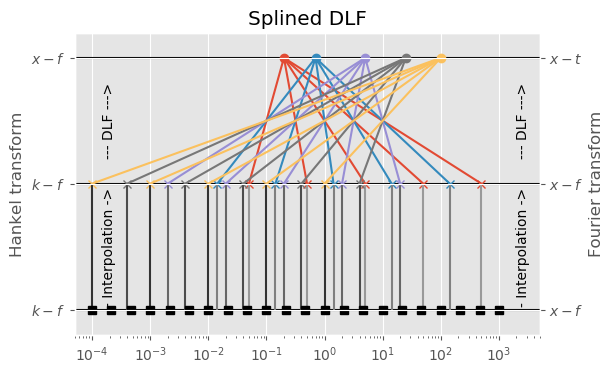

In [8]:
# Required points in the k-domain
d_in_min = np.log10(d_in).min()
d_in_max = np.ceil(np.log10(d_in).max())
pts_per_dec = 3
d_in2 = np.logspace(d_in_min, d_in_max, int((d_in_max-d_in_min)*pts_per_dec+1))

# Print information
print('Points in input-domain    ::', d_out.size)
print('Filter length             ::', base.size)
print('Points per decade         ::', pts_per_dec)
print('Req. pts in output-domain ::', d_in2.size)

# Figure
plt.figure()
plt.title('Splined DLF')
plt.hlines(1, 1e-5, 1e5)
plt.hlines(0.5, 1e-5, 1e5)
plt.hlines(0, 1e-5, 1e5)

# Plot scheme
for i, val in enumerate(d_out):
    for ii, ival in enumerate(d_in[i, :]):
        plt.plot(ival, 0.5, 'C'+str(i)+'x')
        plt.plot([ival, ival], [0, 0.5], str(0.6-0.1*i))
        plt.plot([ival, val], [0.5, 1], 'C'+str(i))
    plt.plot(val, 1, 'C'+str(i)+'o')
    
plt.plot(d_in2, d_in2*0, 'ks')
plt.xscale('log')
plt.xlim([5e-5, 5e3])

# Annotations
plt.text(2e3, 0.25, '- Interpolation ->', rotation=90, va='center')
plt.text(2e3, 0.75, '--- DLF --->', rotation=90, va='center')
plt.text(1.5e-4, 0.25, '- Interpolation ->', rotation=90, va='center')
plt.text(1.5e-4, 0.75, '--- DLF --->', rotation=90, va='center')


plt.yticks([0, 0.5, 1], (r'$k-f$', r'$k-f$', r'$x-f$'))
plt.ylabel('Hankel transform')
plt.ylim([-0.1, 1.1])

plt.gca().twinx()
plt.yticks([0, 0.5, 1], (r'$x-f$', r'$x-f$', r'$x-t$'))
plt.ylabel('Fourier transform')
plt.ylim([-0.1, 1.1])

plt.show()

## 4. Example for the Hankel transform

The following is an example for the Hankel transform. **Be aware that the actual differences in time and accuracy depend highly on the model.** If time or accuracy is a critical issue in your calculation I suggest to run some preliminary tests. It also depends heavily if you have many offsets, or many frequencies, or many layers, as one method might be better for many frequencies but few offsets, but the other method might be better for many offsets but few frequencies.

As general rules we can state that

- the longer the used filter is, or
- the more offsets you have

the higher is the time gain you get by using the lagged convolution or splined version of the DLF.

Here we compare the analytical halfspace solution to the numerical result, using the standard DLF, the lagged convolution DLF, and the splined DLF. Note the oscillating behaviour of the error of the lagged convolution and the splined versions, which comes from the interpolation and is not present in the standard version.

### Define model, calculate analytical solution

In [9]:
x = (np.arange(1, 1001))*10
params = {
    'src': [0, 0, 150],
    'rec': [x, x*0, 200],
    'depth': 0,
    'res': [2e14, 1],
    'freqtime': 1,
    'ab': 11,
    'aniso': [1, 2],
    'xdirect': False,
    'verb': 0,
}

# Used Hankel filter
hfilt = filters.key_201_2009()

# Calculate analytical solution
resp = analytical(params['src'], params['rec'], params['res'][1], params['freqtime'],
                  solution='dhs', aniso=params['aniso'][1], ab=params['ab'], verb=params['verb'])

### Calculate numerically the model using different Hankel options

In [10]:
standard = dipole(**params, opt=None, htarg=hfilt)
laggedco = dipole(**params, opt='spline', htarg=hfilt)
spline10 = dipole(**params, opt='spline', htarg=[hfilt, 10])
spline30 = dipole(**params, opt='spline', htarg=[hfilt, 30])
splin100 = dipole(**params, opt='spline', htarg=[hfilt, 100])

### Results

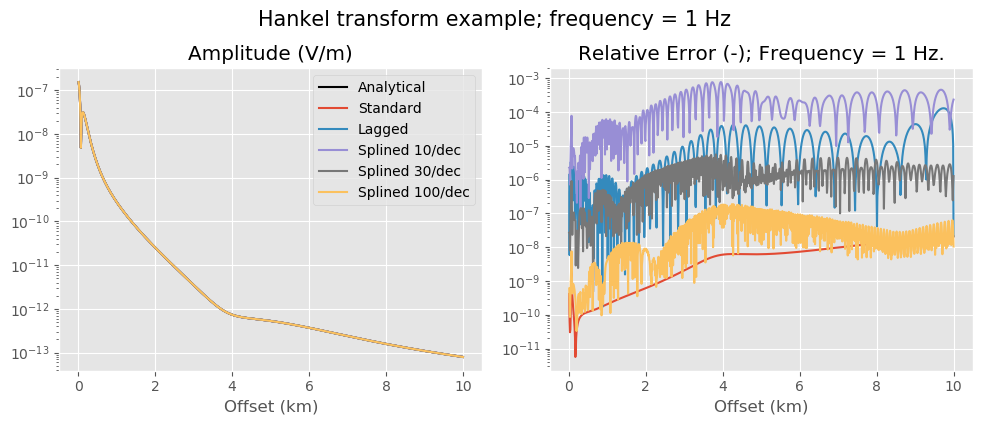

In [11]:
plt.figure(figsize=(10, 4))
plt.suptitle('Hankel transform example; frequency = '+str(params['freqtime'])+' Hz', y=1.05, fontsize=15)

plt.subplot(121)
plt.title('Amplitude (V/m)')
plt.semilogy(x/1000, np.abs(resp), 'k', label='Analytical')
plt.semilogy(x/1000, np.abs(standard), label='Standard')
plt.semilogy(x/1000, np.abs(laggedco), label='Lagged')
plt.semilogy(x/1000, np.abs(spline10), label='Splined 10/dec')
plt.semilogy(x/1000, np.abs(spline30), label='Splined 30/dec')
plt.semilogy(x/1000, np.abs(splin100), label='Splined 100/dec')
plt.xlabel('Offset (km)')
plt.legend()

plt.subplot(122)
plt.title('Relative Error (-); Frequency = '+str(params['freqtime'])+' Hz.')
plt.semilogy(x/1000, np.abs((standard-resp)/resp), label='Standard')
plt.semilogy(x/1000, np.abs((laggedco-resp)/resp), label='Lagged')
plt.semilogy(x/1000, np.abs((spline10-resp)/resp), label='Splined 10/dec')
plt.semilogy(x/1000, np.abs((spline30-resp)/resp), label='Splined 30/dec')
plt.semilogy(x/1000, np.abs((splin100-resp)/resp), label='Splined 100/dec')
plt.xlabel('Offset (km)')
#plt.legend()

plt.tight_layout()
plt.show()

Runtimes and number of required wavenumbers for each method:

Hankel DLF Method  | Time (ms) | # of wavenumbers
-------------------|-----------|-----------------
Standard           | 169       | 201000
Lagged Convolution |   4       | 295
Splined 10/dec     |  95       | 219
Splined 30/dec     |  98       | 653
Splined 50/dec     | 111       | 2172


So the lagged convolution has a relative error between roughly 1e-6 to 1e-4, hence 0.0001 % to 0.01 %, which is more then enough for real-world applications.

If you want to measure the runtime on your machine set `params['verb'] = 2`.

Note: If you use the splined version with about 500 samples per decade you get about the same accuracy as in the standard version. However, you get also about the same runtime.

## 5. Example for the Fourier transform

The same now for the Fourier transform. Obviously, when we use the Fourier transform we also use the Hankel transform. However, in this example we use only one offset. If there is only one offset then the lagged convolution or splined DLF for the Hankel transform do not make sense, and the standard is the fastest. So we use the standard Hankel DLF here. If you have many offsets then that would be different.

As general rules we can state that

- the longer the used filter is, or
- the more times you have

the higher is the time gain you get by using the lagged convolution or splined version of the DLF.

### Define model, calculate analytical solution

In [12]:
t = np.logspace(0, 2, 100)
xt = 2000

tparam = dc(params)
tparam['rec'] = [xt, 0, 200]
tparam['freqtime'] = t
tparam['signal'] = 0  # Impulse response

# Used Fourier filter
ffilt = filters.key_81_CosSin_2009()

# Calculate analytical solution
tresp = analytical(tparam['src'], tparam['rec'], tparam['res'][1], tparam['freqtime'],
                   signal=tparam['signal'], solution='dhs', aniso=tparam['aniso'][1],
                   ab=tparam['ab'], verb=tparam['verb'])

### Calculate numerically the model using different Fourier options

In [13]:
tstandard = dipole(**tparam, opt=None, htarg=hfilt, ftarg=[ffilt, 0])
tlaggedco = dipole(**tparam, opt=None, htarg=hfilt, ftarg=[ffilt, None])
tsplined4 = dipole(**tparam, opt=None, htarg=hfilt, ftarg=[ffilt, 4])
tspline10 = dipole(**tparam, opt=None, htarg=hfilt, ftarg=[ffilt, 10])

### Results

**NOTE:**; The standard DLF for the Fourier transform (`ftarg={'pts_per_dec': 0}`) is only available from `empymod v1.5.2` onwards. This is currently (22 April 2018) not released yet, so you have to use the development version of `empymod` to use it. However, this is only of academic interest, in real-world usage I would never use the standard DLF, but the lagged convolution or a splined one.

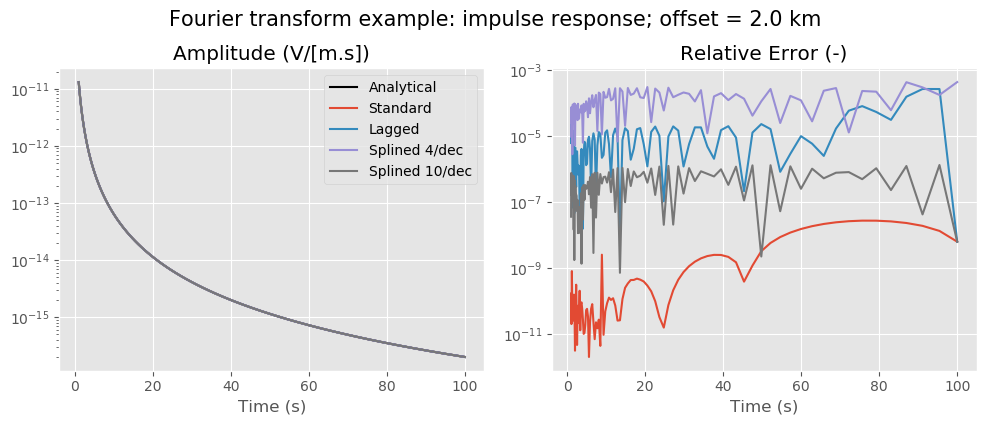

In [14]:
plt.figure(figsize=(10, 4))
plt.suptitle('Fourier transform example: impulse response; offset = '+str(xt/1000)+' km', y=1.05, fontsize=15)

plt.subplot(121)
plt.title('Amplitude (V/[m.s])')
plt.semilogy(t, np.abs(tresp), 'k', label='Analytical')
plt.semilogy(t, np.abs(tstandard), label='Standard')
plt.semilogy(t, np.abs(tlaggedco), label='Lagged')
plt.semilogy(t, np.abs(tsplined4), label='Splined 4/dec')
plt.semilogy(t, np.abs(tspline10), label='Splined 10/dec')
plt.xlabel('Time (s)')
plt.legend()

plt.subplot(122)
plt.title('Relative Error (-)')
plt.semilogy(t, np.abs((tstandard-tresp)/tresp), label='Standard')
plt.semilogy(t, np.abs((tlaggedco-tresp)/tresp), label='Lagged')
plt.semilogy(t, np.abs((tsplined4-tresp)/tresp), label='Splined 4/dec')
plt.semilogy(t, np.abs((tspline10-tresp)/tresp), label='Splined 10/dec')
plt.xlabel('Time (s)')
#plt.legend()

plt.tight_layout()
plt.show()

Runtimes and number of required frequencies for each method:

Fourier DLF Method | Time (ms) | # of frequencies
-------------------|-----------|-----------------
Standard           | 1442      | 8100
Lagged Convolution |   17      |  105
Splined 4/dec      |   14      |   84
Splined 10/dec     |   32      |  208

All methods require 201 wavenumbers (1 offset, filter length is 201).

So the lagged convolution has a relative error of roughly 1e-5, hence 0.001 %, which is more then enough for real-world applications.

If you want to measure the runtime on your machine set `tparam['verb'] = 2`.

In [15]:
from empyscripts import versions
versions('HTML')